In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [4]:
disease_type = ['Healthy','Early_blight','Late_blight']
data_path = 'E:/Crop_disease/dataset/potato/'
train_dir = os.path.join(data_path)

In [5]:
os.listdir(train_dir)

['Early_blight', 'healthy', 'Late_blight']

In [6]:
train_data = []
for id, sp in enumerate(disease_type):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [7]:
train.head(500)

,File,DiseaseID,Disease Type
0,Healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2__...,0,Healthy
1,Healthy/03da9931-e514-4cc7-b04a-8f474a133ce5__...,0,Healthy
2,Healthy/04481ca2-f94c-457e-b785-1ac05800b7ec__...,0,Healthy
3,Healthy/046641c1-f837-49eb-b5f2-4109910a027c__...,0,Healthy
4,Healthy/07dfb451-4378-49d1-b699-33a5fc49ff07__...,0,Healthy
...,...,...,...
495,Healthy/IMG20230103123418.jpg,0,Healthy
496,Healthy/IMG20230103123425.jpg,0,Healthy
497,Healthy/IMG20230103123435.jpg,0,Healthy
498,Healthy/IMG20230103123441.jpg,0,Healthy


In [8]:
len(train)

3293

In [9]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Late_blight/fb9dc049-ec76-4502-9a11-13fb62a26e...,2,Late_blight
1,Late_blight/faf67766-afc0-4f41-af0b-a3971fe325...,2,Late_blight
2,Late_blight/e9cc84b7-fc38-4e65-a129-c7a63df767...,2,Late_blight
3,Early_blight/IMG20230103104037.jpg,1,Early_blight
4,Late_blight/36d2885d-0bc7-4346-8a13-383e1533a6...,2,Late_blight


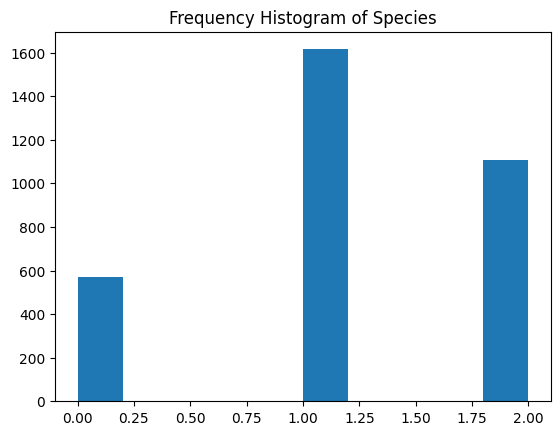

<Figure size 1200x1200 with 0 Axes>

In [10]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

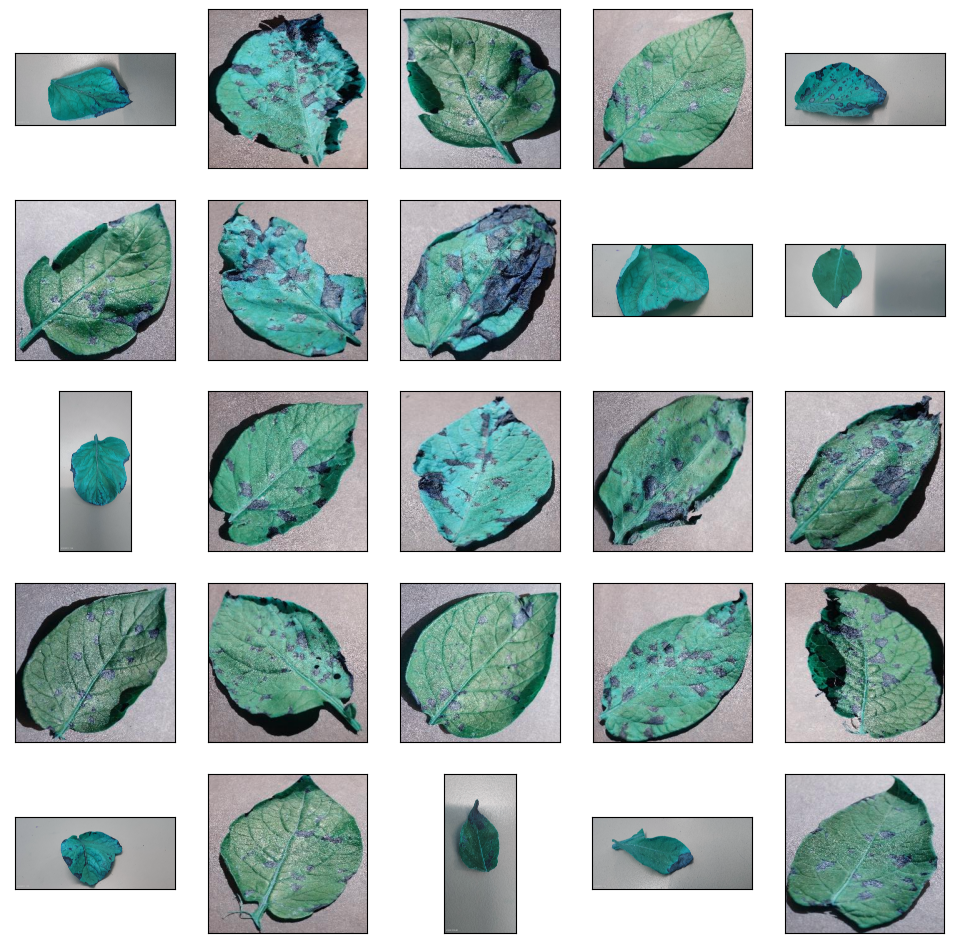

In [11]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Early_blight', 5, 5)

In [12]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [13]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3293it [03:41, 14.85it/s]


Train Shape: (3293, 224, 224, 3)


In [14]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [15]:
BATCH_SIZE = 16

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

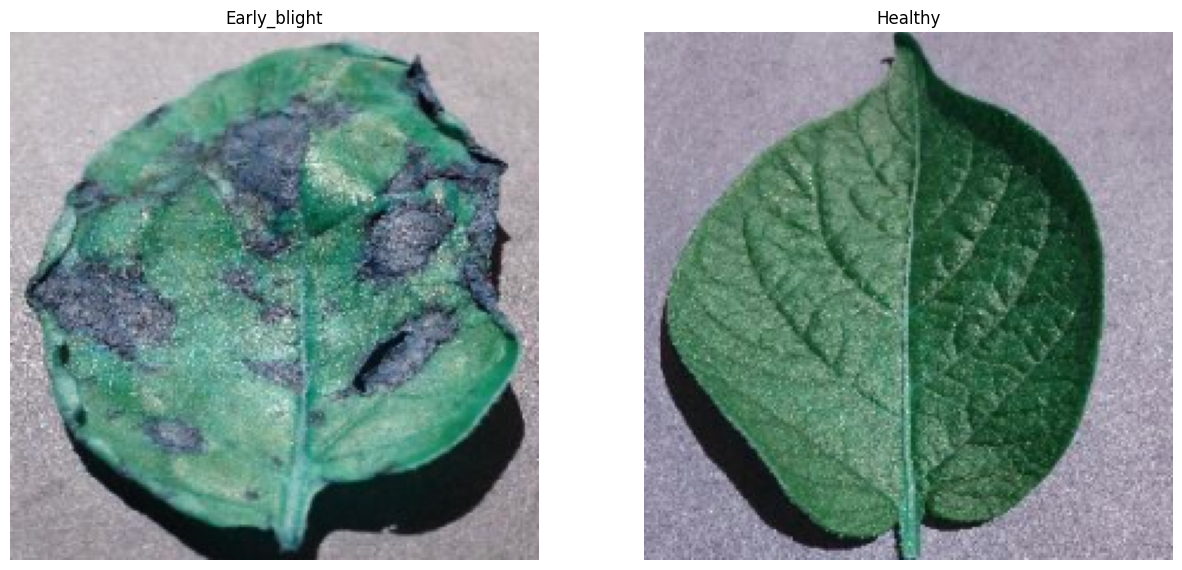

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_type[np.argmax(Y_train[i])])

In [17]:
EPOCHS = 30
SIZE=224
N_ch=3

In [18]:
def build_densenet():
    densenet = DenseNet121(weights=None, include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [19]:
from collections import Counter
print(Counter(train['Disease Type']))

Counter({'Early_blight': 1615, 'Late_blight': 1106, 'Healthy': 572})


In [30]:
class_weights = {0:1615/3293, 1:572/3293, 2:1106/3293}

In [31]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('potato_densenet.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
               steps_per_epoch=X_train.shape[0] // 128,
               epochs=60,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val),
                class_weight=class_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

C:\Users\User1\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/60

Epoch 1: val_loss improved from inf to 1.20981, saving model to potato_densenet.h5
20/20 - 45s - loss: 0.3995 - accuracy: 0.4852 - val_loss: 1.2098 - val_accuracy: 0.3156 - lr: 0.0020 - 45s/epoch - 2s/step
Epoch 2/60

Epoch 2: val_loss did not improve from 1.20981
20/20 - 29s - loss: 0.2935 - accuracy: 0.5822 - val_loss: 1.3867 - val_accuracy: 0.3156 - lr: 0.0020 - 29s/epoch - 1s/step
Epoch 3/60

Epoch 3: val_loss did not improve from 1.20981
20/20 - 28s - loss: 0.2576 - accuracy: 0.6361 - val_loss: 1.5960 - val_accuracy: 0.3156 - lr: 0.0020 - 28s/epoch - 1s/step
Epoch 4/60

Epoch 4: val_loss did not improve from 1.20981
20/20 - 29s - loss: 0.2561 - accuracy: 0.6325 - val_loss: 1.8058 - val_accuracy: 0.3156 - lr: 0.0020 - 29s/epoch - 1s/step
Epoch 5/60

Epoch 5: val_loss did not improve from 1.20981
20/20 - 29s - loss: 0.2195 - accuracy: 0.6875 - val_loss: 1.9868 - val_accuracy: 0.3156 - lr: 0.0020 - 29s/epoch - 1s/step
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learni

Epoch 45/60

Epoch 45: val_loss did not improve from 0.40814
20/20 - 29s - loss: 0.0727 - accuracy: 0.8927 - val_loss: 0.8018 - val_accuracy: 0.8042 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 46/60

Epoch 46: val_loss did not improve from 0.40814
20/20 - 29s - loss: 0.0664 - accuracy: 0.9002 - val_loss: 0.4402 - val_accuracy: 0.8422 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 47/60

Epoch 47: val_loss did not improve from 0.40814
20/20 - 29s - loss: 0.0666 - accuracy: 0.9026 - val_loss: 0.8109 - val_accuracy: 0.7739 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 48/60

Epoch 48: val_loss improved from 0.40814 to 0.40173, saving model to potato_densenet.h5
20/20 - 30s - loss: 0.0663 - accuracy: 0.8990 - val_loss: 0.4017 - val_accuracy: 0.8437 - lr: 0.0010 - 30s/epoch - 2s/step
Epoch 49/60

Epoch 49: val_loss did not improve from 0.40173
20/20 - 29s - loss: 0.0696 - accuracy: 0.8970 - val_loss: 0.6158 - val_accuracy: 0.8103 - lr: 0.0010 - 29s/epoch - 1s/step
Epoch 50/60

Epoch 50: val_loss did not 

In [32]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

21/21 [==============================] - 2s 110ms/step - loss: 0.3716 - accuracy: 0.8558
Final Loss: 0.37155622243881226, Final Accuracy: 0.8558421730995178


21/21 [==============================] - 4s 103ms/step


Text(0.5, 192.58159722222217, 'Predicted')

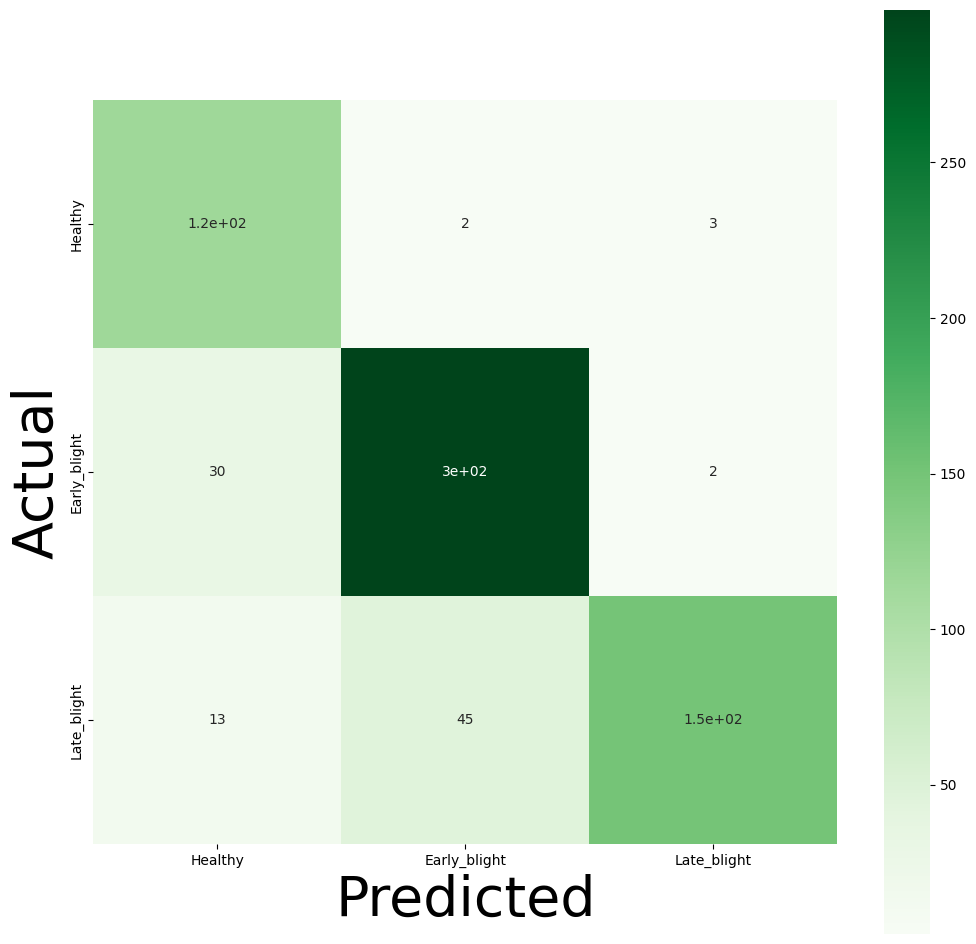

In [33]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_type, yticklabels=disease_type)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(Y_true, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       120
           1       0.86      0.90      0.88       331
           2       0.97      0.72      0.83       208

    accuracy                           0.86       659
   macro avg       0.85      0.86      0.85       659
weighted avg       0.87      0.86      0.86       659



In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print(f1_score(Y_true, Y_pred, average='weighted'))

0.8551693271987235


In [37]:
print(precision_score(Y_true, Y_pred, average='weighted'))

0.8720328785840352


In [38]:
print(recall_score(Y_true, Y_pred, average='weighted'))

0.8558421851289834


In [39]:
who is accessing this system?
?????????
with User1???? please stop using it?????

SyntaxError: invalid syntax (438805018.py, line 3)

In [ ]:
# # accuracy plot 
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# # loss plot
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()